## CIFAR-10 Data Loading and Visualization with PyTorch

Files already downloaded and verified
Files already downloaded and verified


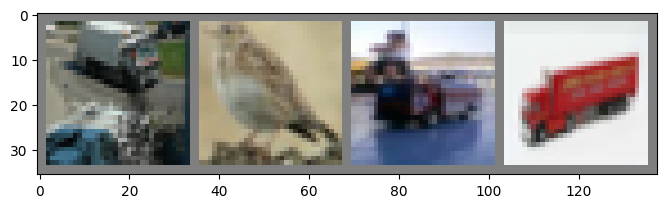

Labels:  truck  bird truck truck


In [1]:
# Required Libraries
# Importing all necessary libraries and modules from PyTorch, NumPy, and torchvision for building and training neural networks,
# as well as for data manipulation and visualization.
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Dataset and DataLoader Setup
# Preparing the CIFAR-10 dataset for training and testing.
# This includes defining transformations to normalize the dataset and setting up DataLoaders for batching, shuffling, and parallel processing.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Training set
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform) 

# DataLoader for training set
trainloader = DataLoader(trainset, batch_size=24, shuffle=True, num_workers=2)  

# Test set
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)  

# DataLoader for test set
testloader = DataLoader(testset, batch_size=24, shuffle=False, num_workers=2)  

# Loading a Batch of Images
# Loading a single batch of images from the training DataLoader to visualize and inspect the data.
dataiter = iter(trainloader)
images, labels = next(dataiter)

# A utility function to unnormalize and display a batch of images using matplotlib.
def show_images(img):
    img = img / 2 + 0.5     # Unnormalize the images
    npimg = img.numpy()     # Convert the tensor to a NumPy array for visualization
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Transpose the dimensions to display properly
    plt.show()

# Displaying Images and Labels
# Using the show_images function to display a grid of images from the dataset. Additionally, printing the corresponding labels for the displayed images.
plt.figure(figsize=(8,8))
show_images(vutils.make_grid(images[:4]))  # Displaying the first 4 images in a grid

# Printing labels for the first 4 images
print('Labels: ', ' '.join('%5s' % trainset.classes[labels[j]] for j in range(4)))


## Intermediate Block

In [2]:
class IntermediateBlock(nn.Module):
    #Here I am Initializing the IntermediateBlock with parameters for input channels, output channels, number of layers, and dropout probability.
    def __init__(self, in_channels, out_channels, num_layers, dropout_prob=0.5):
        super(IntermediateBlock, self).__init__()  # Initialize my parent class, nn.Module.
        
        # I have created a ModuleList of layers, each composed of a Conv2d layer, BatchNorm, ReLU activation, and Dropout.
        # This list is generated based on the specified number of layers. It's a dynamic way to add multiple similar blocks.
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),  # Convolution layer with its specific parameters
                nn.BatchNorm2d(out_channels),  # Normalizing the output of the convolution for faster, more stable training.
                nn.ReLU(inplace=True),  # ReLU activation function for introducing non-linearity in model
                nn.Dropout(dropout_prob)  # Dropout to prevent overfitting by randomly setting some activations to zero.
            ) for _ in range(num_layers)
        ])
        
        # A fully connected layer to transform the averaged feature map dimensions to the number of layers.
        # This will be used later to weigh each layer's contribution in the output.
        self.fc = nn.Linear(in_channels, num_layers)

    # Here I am Defining how the input tensor 'x' is processed through the block.
    def forward(self, x):
        # I calculated the mean of the input feature map across the spatial dimensions, resulting in a vector per example.
        m = torch.mean(x, dim=[2, 3])
        
        # Applying a softmax to the output of the fully connected layer to obtain a probability distribution.
        # This distribution is used to weigh the contributions of each layer.
        a = F.softmax(self.fc(m), dim=1)
        
        # Preparing a tensor filled with zeros that will hold the weighted sum of the layer outputs.
        x_prime = torch.zeros_like(self.layers[0](x))
        
        # Iterating through each layer, applying it to the input, and accumulating the weighted output.
        for i, layer in enumerate(self.layers):
            # The weighting is done by multiplying the layer's output with the corresponding weight from 'a'.
            x_prime += a[:, i:i+1, None, None] * layer(x)
        
        # Returning the aggregated output tensor, which combines features learned by different layers, weighted by 'a'.
        return x_prime


## Output Block

In [3]:
class OutputBlock(nn.Module):
    # When I'm setting up, I need to know the input size, the final output size, and any hidden layers in between.
    def __init__(self, in_channels, out_features, hidden_layers=None):
        super(OutputBlock, self).__init__()  # Here I start by initializing my parent class, nn.Module.
        
        # I used an adaptive average pooling layer to reduce the spatial dimensions to 1x1, making it easier to connect to fully connected layers.
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Here, I am preparing to build my sequence of layers. If no specific hidden layers were provided, I start with an empty list.
        layers = []
        if hidden_layers is None:
            hidden_layers = []

        # 'prev_channels' keeps track of the size of the input for the next layer. Initially, it's the input size to this block.
        prev_channels = in_channels

        # Now, I am looping through each specified hidden layer size to create a linear layer followed by a ReLU activation.
        for hidden_channels in hidden_layers:
            layers.append(nn.Linear(prev_channels, hidden_channels))  # Adds a fully connected layer.
            layers.append(nn.ReLU(inplace=True))  # Adds a ReLU activation function right after.
            prev_channels = hidden_channels  # Updates the input size for the next layer.

        # After setting up any hidden layers, I add one more linear layer to get to the desired output size.
        layers.append(nn.Linear(prev_channels, out_features))
        
        # 'fc_layers' is a sequence of all these layers packaged together.
        self.fc_layers = nn.Sequential(*layers)

    # For the forward pass, this is how I process the input 'x'.
    def forward(self, x):
        # First, I apply the adaptive average pooling to reduce each channel to a single value.
        o = self.avgpool(x).view(x.size(0), -1)  # Then, I flatten it to prepare for the fully connected layers.
        
        # I passed this flattened vector through the fully connected layers to get the final output.
        o = self.fc_layers(o)
        return o


## Implementing Custom CNN class using intermediate and output block

In [4]:
class CustomCNN(nn.Module):
    # Here I'm set up for a task with 10 classes.
    def __init__(self, num_classes=10):
        super(CustomCNN, self).__init__()
        
        # Here, I stack my intermediate blocks. Each block increases in complexity and channels as we go deeper.
        # Starting with 3 input channels, I gradually increase to 64, then 128, and finally 256 channels.
        # Each IntermediateBlock has 2 layers and a dropout probability of 0.5 to prevent overfitting.
        self.intermediate_blocks = nn.Sequential(
            IntermediateBlock(3, 64, 2, 0.5),
            IntermediateBlock(64, 128, 2, 0.5),
            IntermediateBlock(128, 256, 2, 0.5)
        )
        
        # After processing the image through convolutional layers, I'm ready to make predictions.
        # My output block takes the features, processes them through an additional hidden layer of 512 units, and finally outputs a prediction for the number of classes specified.
        self.output_block = OutputBlock(256, num_classes, hidden_layers=[512])

    
    def forward(self, x):
        # First, the data goes through each intermediate block where features are extracted and refined.
        x = self.intermediate_blocks(x)
        
        # After getting through all the convolutions and adaptations, it's time for the final decision.
        # The output block takes in all that I have learned and decides which class the input belongs to.
        x = self.output_block(x)
        
        return x



## Model Setup and Training and Testing across all Epochs

In [5]:
# Model Setup and Configuration
#Here I am Setting up my model and determining the compute device based on GPU availability.
model = CustomCNN(num_classes=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Sending my model to the chosen device to leverage faster computations.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Using Adam optimizer for efficient learning.

# Progress Tracking
# Preparing to track my learning progress over the training sessions.
# To store loss for each training batch.
num_epochs = 60
epoch_train_losses = []
epoch_test_losses = []
epoch_train_accuracies = []
epoch_test_accuracies = []
batch_train_losses = []  

# Training and Testing Loop
# This loop helps me learn from the training data and validate my learning on the test data.
for epoch in range(num_epochs):
    model.train()  # Engaging training mode which enables certain layers like Dropout.
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Ensure data is on the correct device.
        optimizer.zero_grad()  # Clearing old gradients before a new optimization step.
        outputs = model(inputs)  # Forward pass to get the predictions.
        loss = criterion(outputs, labels)  # Calculating loss between predictions and true labels.
        loss.backward()  # Backpropagate the error to adjust the weights.
        optimizer.step()  # Update the model parameters.

        batch_loss = loss.item()
        running_loss += batch_loss
        batch_train_losses.append(batch_loss)  # Record loss per batch for detailed monitoring.

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Summarizing performance after each epoch to monitor how well the training is going.
    epoch_train_losses.append(running_loss / len(trainloader))
    epoch_train_accuracies.append(100 * correct_train / total_train)
    
    model.eval()  # Switch to evaluation mode which disables certain layers like Dropout.
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():  # No need to compute gradients when testing.
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    epoch_test_losses.append(test_loss / len(testloader))
    epoch_test_accuracies.append(100 * correct_test / total_test)

    # Reporting the results at the end of each epoch
    print(f'Epoch {epoch + 1} - Train Loss: {epoch_train_losses[-1]:.2f}, Train Accuracy: {epoch_train_accuracies[-1]:.2f} %, Test Loss: {epoch_test_losses[-1]:.2f}, Test Accuracy: {epoch_test_accuracies[-1]:.2f} %')

# Post-Training Analysis
# Calculating overall testing performance to evaluate the model’s effectiveness.
average_test_accuracy = sum(epoch_test_accuracies) / len(epoch_test_accuracies)
best_epoch = epoch_test_accuracies.index(max(epoch_test_accuracies)) + 1
max_test_accuracy = max(epoch_test_accuracies)
print(f'Average Test Accuracy: {average_test_accuracy:.2f} %')
print(f'Best Epoch: {best_epoch} with Test Accuracy: {max_test_accuracy:.2f} %')


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1702400440653/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1 - Train Loss: 1.58, Train Accuracy: 41.19 %, Test Loss: 1.38, Test Accuracy: 50.43 %
Epoch 2 - Train Loss: 1.29, Train Accuracy: 52.97 %, Test Loss: 1.24, Test Accuracy: 54.64 %
Epoch 3 - Train Loss: 1.18, Train Accuracy: 57.53 %, Test Loss: 1.23, Test Accuracy: 55.01 %
Epoch 4 - Train Loss: 1.10, Train Accuracy: 60.47 %, Test Loss: 1.12, Test Accuracy: 59.85 %
Epoch 5 - Train Loss: 1.05, Train Accuracy: 62.33 %, Test Loss: 1.08, Test Accuracy: 62.45 %
Epoch 6 - Train Loss: 1.00, Train Accuracy: 64.17 %, Test Loss: 0.99, Test Accuracy: 64.75 %
Epoch 7 - Train Loss: 0.96, Train Accuracy: 65.40 %, Test Loss: 1.00, Test Accuracy: 65.31 %
Epoch 8 - Train Loss: 0.93, Train Accuracy: 66.94 %, Test Loss: 0.90, Test Accuracy: 68.60 %
Epoch 9 - Train Loss: 0.90, Train Accuracy: 68.02 %, Test Loss: 0.92, Test Accuracy: 67.81 %
Epoch 10 - Train Loss: 0.87, Train Accuracy: 69.19 %, Test Loss: 0.84, Test Accuracy: 69.84 %
Epoch 11 - Train Loss: 0.84, Train Accuracy: 70.09 %, Test Loss: 0.86

## Plotting the results

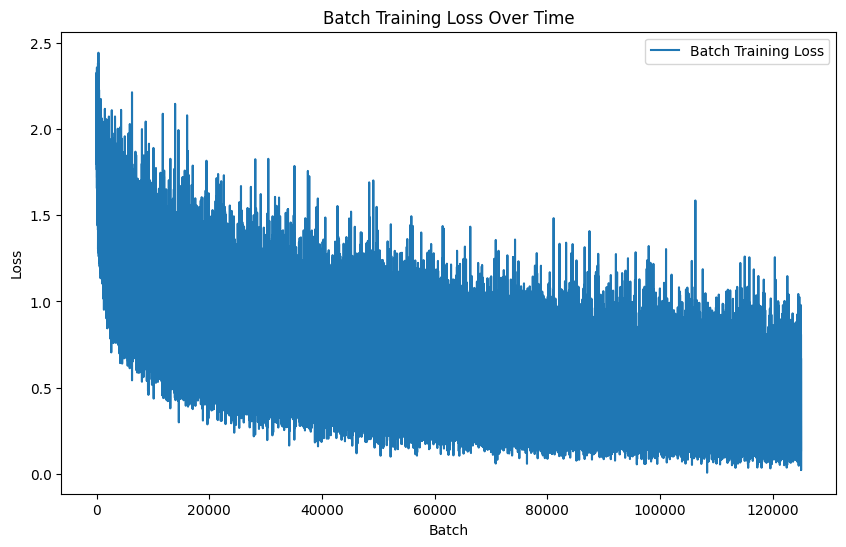

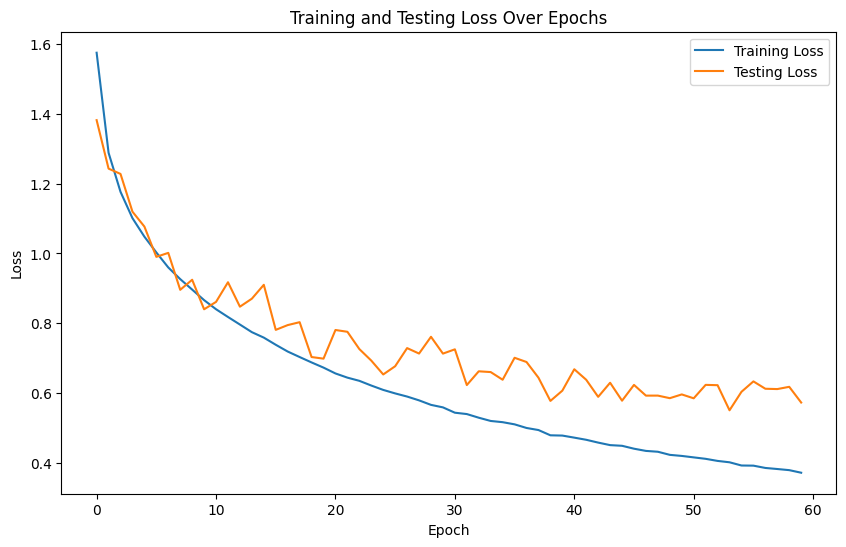

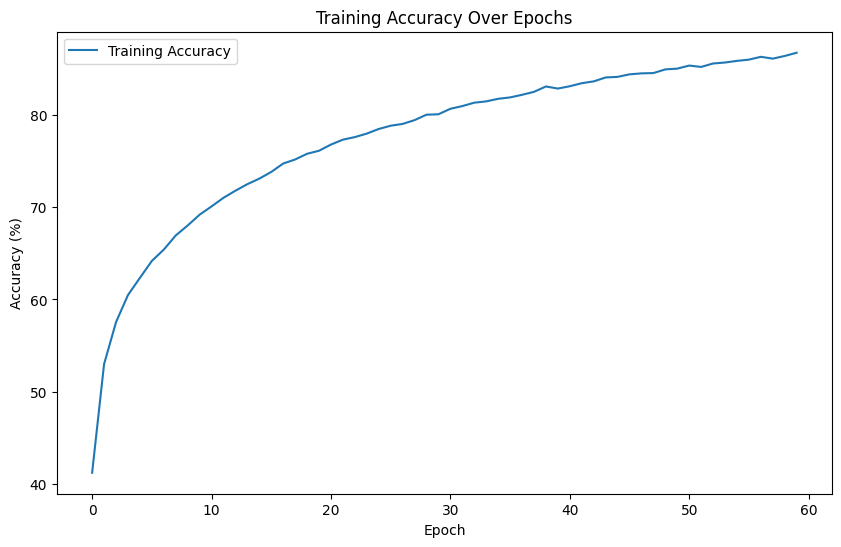

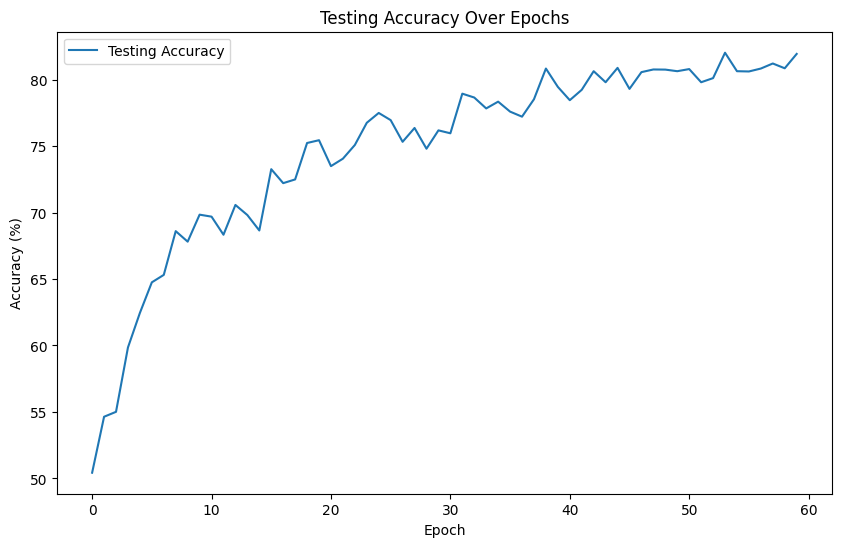

In [6]:
# Plotting Batch Training Loss
plt.figure(figsize=(10, 6))
plt.plot(batch_train_losses, label='Batch Training Loss')
plt.title('Batch Training Loss Over Time')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Epoch Training and Testing Loss
plt.figure(figsize=(10, 6))
plt.plot(epoch_train_losses, label='Training Loss')
plt.plot(epoch_test_losses, label='Testing Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Training Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epoch_train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# Plotting Testing Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epoch_test_accuracies, label='Testing Accuracy')
plt.title('Testing Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()